### Repeated-measures ANOVA example with 3 conditions (auditory, visual, and audiovisual)

Based on [Crosse et al (2015)](https://www.jneurosci.org/content/35/42/14195.full)

This is the Python notebook I used to simulate the data and generate the figures for my lecture on repeated-measures ANOVA.
To run the code, click on each block (a "cell") of code and click the "play" button near the top of the page. There is also a button at the top of the page to run all of the cells (the two right arrows, or "fast-forward icon", at the top).

*This was partly written with the help of Microsoft Copilot.*

In [1]:
# Import necessary python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import f

# Set styles for plotting
sns.set_style('whitegrid')
sns.set_context('talk')

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Set random seed for reproducibility
#np.random.seed(42) ## I used this randomization seed when I made the figures in my lecture. 
    ## Otherwise, new data will be generated each time you run this.
    ## To remove the line above, type "#" just before the "np.", and you will get new data each time this is run

# Number of subjects and levels (conditions)
n_subjects = 20
levels = ['AV','A','V']
n_levels = len(levels)

# Mean values and standard deviation for each level
means = [600, 650, 800]
std_dev_sbj = 100 # this is the st. dev. across participants
std_dev_wthn = 30 # this is the st. dev. within participants

# Simulate data
data = []
for subject in range(1, n_subjects + 1):
    sbj_avg = np.random.normal(0, std_dev_sbj)
    for level in range(1, n_levels + 1):
        value = np.random.normal(means[level - 1], std_dev_wthn)
        value = value+sbj_avg
        data.append([subject, levels[level-1], value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Response time'])

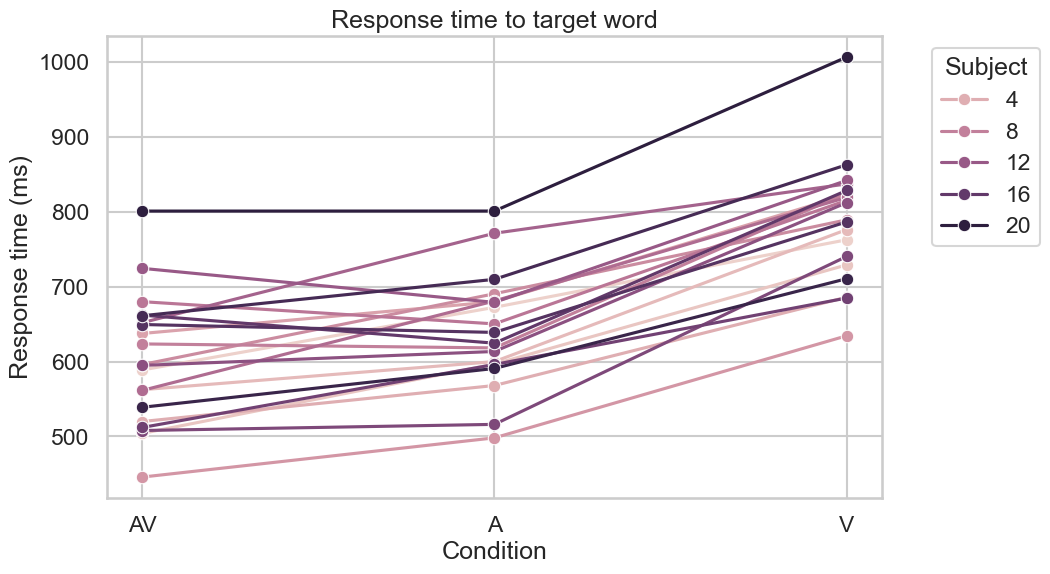

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Condition', y='Response time', hue='Subject', marker='o')
plt.title('Response time to target word')
plt.xlabel('Condition')
plt.ylabel('Response time (ms)')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [6]:
# Run the repeated-measures ANOVA
aov = pg.rm_anova(dv='Response time', within='Condition', subject='Subject', data=df, detailed=True, effsize="ng2")
# Display the overall results
print(aov)

      Source             SS  DF             MS           F         p-unc  \
0  Condition  391135.863212   2  195567.931606  205.265421  4.283852e-21   
1      Error   36204.741006  38     952.756342         NaN           NaN   

        ng2       eps  
0  0.515477  0.852405  
1       NaN       NaN  


In [7]:
# Display individual important items
# - Degrees of freedom
dof1 = aov['DF'][0]
dof2 = aov['DF'][1]
print(f'Degrees of freedom: ({dof1},{dof2})')

# - F-statistic
Fstat = aov['F'][0]
print(f"F-statistic = {Fstat}")

# - p-value
print(f"p = {aov['p-unc'][0]}")

# - partial eta-squared
print(f"generalized eta-squared = {aov['ng2'][0]}")

Degrees of freedom: (2,38)
F-statistic = 205.2654208986486
p = 4.2838516352278375e-21
generalized eta-squared = 0.5154767405071026


In [8]:
# rm_anova does not display the between subjects sum-of-squares. Calculate this effect manually
SS_total = sum(np.power(df['Response time'] - df['Response time'].mean(),2))
print(f'Total SS = {SS_total}')
sbj_mean = df[['Subject','Response time']].groupby('Subject').mean()
SS_sbj = sum(np.power(sbj_mean['Response time'] - df['Response time'].mean(),2)) * n_levels
print(f'Between-subject SS = {SS_sbj}')
print(f'Within-subject SS = {SS_total - SS_sbj}')

# Does SS_sbj + SS_condition + SS_error = SS_total?
print(f"SS_sbj + SS_cond + SS_error = {SS_sbj + aov['SS'][0] + aov['SS'][1]}")

Total SS = 758784.6986597258
Between-subject SS = 331444.09444243024
Within-subject SS = 427340.6042172956
SS_sbj + SS_cond + SS_error = 758784.6986597257


### Show the F-statistic and p-value calculation

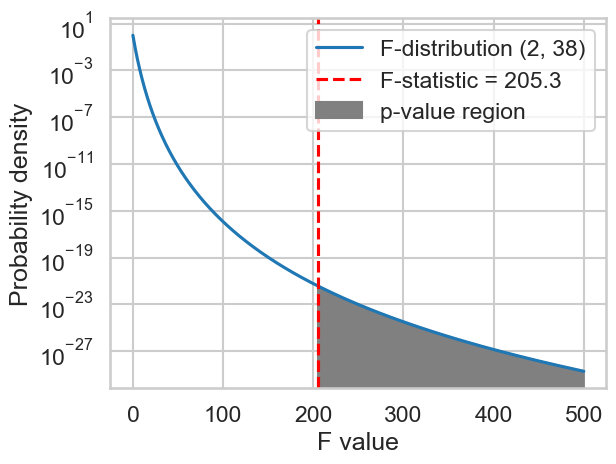

In [9]:
# Define the range of x values
x = np.linspace(0, 500, 1000)

# Calculate the F-distribution values
y = f.pdf(x, dof1, dof2)

# Plot the F-distribution
plt.plot(x, y, label=f'F-distribution ({dof1}, {dof2})')

# Define the F-statistic value
f_stat = Fstat

# Label the F-statistic value on the plot
plt.axvline(f_stat, color='r', linestyle='--', label=f'F-statistic = {f_stat:.1f}')

# Shade the region for p-value calculation
x_fill = np.linspace(f_stat, 500, 1000)
y_fill = f.pdf(x_fill, dof1, dof2)
plt.fill_between(x_fill, y_fill, alpha=1, color='gray', label='p-value region')

# Add labels and title
plt.yscale('log')
plt.xlabel('F value')
plt.ylabel('Probability density')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create the same plot, using the linear y axis
plt.plot(x, y, label=f'F-distribution ({dof1}, {dof2})') # Null distribution
plt.axvline(f_stat, color='r', linestyle='--', label=f'F-statistic = {f_stat:.1f}')
plt.fill_between(x_fill, y_fill, alpha=1, color='gray', label='p-value region')
plt.yscale('linear')
plt.xlabel('F value')
plt.ylabel('Probability density')
plt.legend()

# Show the plot
plt.show()

### Demonstration of sphericity
Plot the relationship between pairs of conditions, as well as the variability across subjects in the difference between conditions.

In [ ]:
# Make three plots showing the correlations between pairs of conditions
paired_cond = df.pivot(columns='Condition',values='Response time',index='Subject')
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.regplot(x='A', y='V', data=paired_cond, ax=axes[0])
sns.regplot(x='AV', y='V', data=paired_cond, ax=axes[1])
sns.regplot(x='AV', y='A', data=paired_cond, ax=axes[2])

# Set to the same axes
for n in range(3):
    axes[n].set_xlim(400,1000)
    axes[n].set_ylim(400,1000)

plt.tight_layout()
plt.show()

In [ ]:
# Make the same set of subplots showing the variability in the difference between conditions
diff_cond = {
    'V-A': paired_cond['V']-paired_cond['A'],
    'V-AV': paired_cond['V']-paired_cond['AV'],
    'A-AV': paired_cond['A']-paired_cond['AV']
}
df_diff = pd.DataFrame(diff_cond)

fig, axes = plt.subplots(figsize=(7,5))
sns.boxplot(data=df_diff)
sns.stripplot(data=df_diff, color=".3", size=6)
axes.set(xlabel="Condition",ylabel="Difference in response time")
plt.show()

In [ ]:
# Display the result of Mauchly's test for sphericity
spher, W, chi2, dof, pval = pg.sphericity(data=df, dv='Response time', within='Condition', subject='Subject')
print(f'Sphericity: W = {W:.3f}, dof = {dof}, p = {pval:.3f}')

### Multiple comparisons

In [ ]:
# Calculate pairwise comparisons
## By default Python uses paired t-tests (there isn't really a function to do emmeans in Python)
## The Bonferroni corrected p-value is listed in the table under "p-corr"
posthocs = pg.pairwise_tests(dv='Response time', within='Condition', subject='Subject', data=df, padjust='bonf')
print(posthocs)